In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('IPN31152N.csv',index_col='DATE',parse_dates=True)

<Axes: xlabel='DATE'>

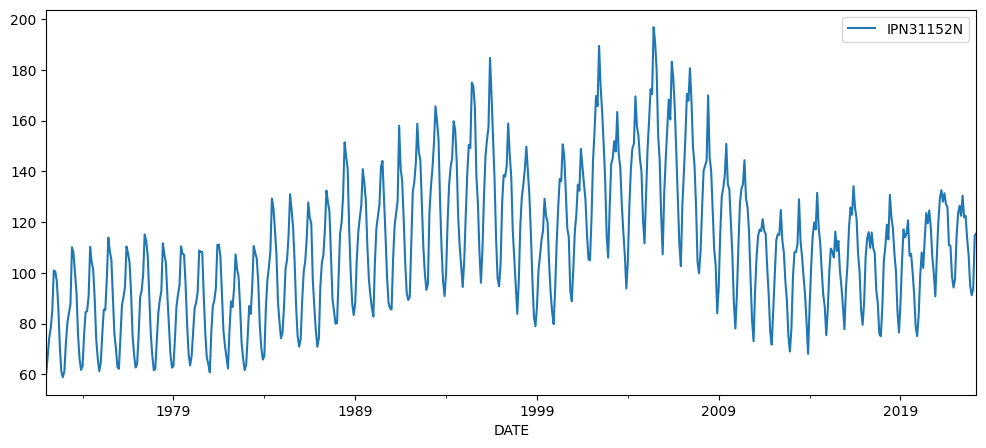

In [3]:
df.plot(figsize=(12,5))

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335


In [5]:
df.columns = ['Production']

## Разбивка обучения/тестирования

In [6]:
len(df)

615

In [7]:
len(df)-18

597

In [8]:
test_size = 24
test_ind = len(df)-test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
len(test)

24

## Масштабирование данных

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [14]:
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

## Генератор временных рядов

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaler_train, scaler_train, length=length, batch_size=1)

In [17]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [18]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.00946844 0.06107885 0.11324444 0.14143379 0.18979649 0.30491157
 0.30149644 0.27411739 0.19733776 0.08531384 0.0156138  0.        ]
Cela prédit ce y : 
 [[0.01773956]]


In [19]:
scaler_train

array([[0.00946844],
       [0.06107885],
       [0.11324444],
       [0.14143379],
       [0.18979649],
       [0.30491157],
       [0.30149644],
       [0.27411739],
       [0.19733776],
       [0.08531384],
       [0.0156138 ],
       [0.        ],
       [0.01773956],
       [0.09849312],
       [0.15587563],
       [0.18355909],
       [0.20875512],
       [0.37144363],
       [0.35419836],
       [0.29812914],
       [0.23970223],
       [0.12102706],
       [0.05289471],
       [0.02087566],
       [0.03141387],
       [0.12131987],
       [0.18620451],
       [0.18853176],
       [0.23180437],
       [0.37259312],
       [0.32887912],
       [0.30805709],
       [0.22407684],
       [0.10933284],
       [0.05452473],
       [0.01750039],
       [0.04077214],
       [0.12185258],
       [0.19275429],
       [0.19219042],
       [0.28135425],
       [0.39892125],
       [0.35979941],
       [0.33565213],
       [0.22869872],
       [0.1240182 ],
       [0.08401142],
       [0.029

## Создание модели

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [21]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [22]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## Ранняя остановка и создание генератора проверки

ПРИМЕЧАНИЕ. Размер набора данных scaled_test ДОЛЖЕН быть больше, чем выбранная длина для ваших пакетов. Посмотрите видео для получения дополнительной информации об этом.

In [25]:
validation_generator = TimeseriesGenerator(scaler_test,scaler_test, length=length, batch_size=1)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [27]:
# ajustement du modèle
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
579/579 [==============================] - 4s 4ms/step - loss: 0.0209 - val_loss: 0.0031
Epoch 2/20
579/579 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 3/20
579/579 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 4/20
579/579 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 5/20
579/579 [==============================] - 2s 4ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 6/20
579/579 [==============================] - 2s 4ms/step - loss: 0.0034 - val_loss: 0.0021


**Задание: Проследить историю потерь, произошедших во время обучения.**

In [28]:
losses = pd.DataFrame(model.history.history)

<Axes: >

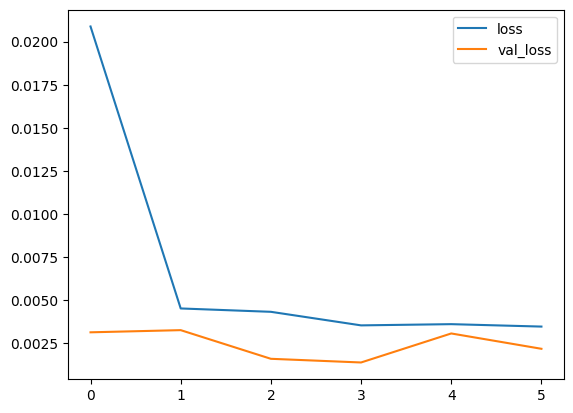

In [29]:
losses.plot()

## Оценка на тестовых данных

In [92]:
#boucle pour predire tous les points de test
test_predictions = []
first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [90]:
model.predict(first_eval_batch) #on predit le premier point de test

1/1 [==============================] - 0s 127ms/step


array([[0.385402]], dtype=float32)

In [91]:
scaler_test[0] #on compare avec le premier point de test

array([0.37557194])

In [93]:
first_eval_batch

array([[0.34471035],
       [0.29659262],
       [0.23086797],
       [0.34511622],
       [0.44446965],
       [0.51066033],
       [0.5342394 ],
       [0.50161951],
       [0.52567547],
       [0.49443555],
       [0.48659495],
       [0.37762087]])

In [94]:
predicted_value = [[[52]]] #on initialise predicted_value
np.append(current_batch[:,1:,:],[[[52]]],axis=1) #on prend le dernier point de current_batch et on lui ajoute le point suivant de scaled_train

array([[[ 0.29659262],
        [ 0.23086797],
        [ 0.34511622],
        [ 0.44446965],
        [ 0.51066033],
        [ 0.5342394 ],
        [ 0.50161951],
        [ 0.52567547],
        [ 0.49443555],
        [ 0.48659495],
        [ 0.37762087],
        [52.        ]]])

In [99]:
test_predictions = []

first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


## Обратные преобразования и сравнение

In [100]:
test_predictions

[array([0.385402], dtype=float32),
 array([0.34471074], dtype=float32),
 array([0.3518338], dtype=float32),
 array([0.42520246], dtype=float32),
 array([0.5104024], dtype=float32),
 array([0.5818505], dtype=float32),
 array([0.62191147], dtype=float32),
 array([0.638018], dtype=float32),
 array([0.6427042], dtype=float32),
 array([0.6232574], dtype=float32),
 array([0.57511383], dtype=float32),
 array([0.5083716], dtype=float32),
 array([0.4675692], dtype=float32),
 array([0.43751413], dtype=float32),
 array([0.45431906], dtype=float32),
 array([0.51305676], dtype=float32),
 array([0.5896095], dtype=float32),
 array([0.66368717], dtype=float32)]

In [101]:
scaler_test

array([[0.37557194],
       [0.28772429],
       [0.25639522],
       [0.28046496],
       [0.40039616],
       [0.46663323],
       [0.48980859],
       [0.46119235],
       [0.5187633 ],
       [0.45688212],
       [0.46089302],
       [0.39620335],
       [0.34758553],
       [0.26176869],
       [0.23401204],
       [0.25289094],
       [0.40440996],
       [0.41102859]])

In [102]:
true_predictions = scaler.inverse_transform(test_predictions)

In [103]:
true_predictions

array([[112.02199326],
       [106.40765376],
       [107.3904506 ],
       [117.51342661],
       [129.26880921],
       [139.12680303],
       [144.65417482],
       [146.876461  ],
       [147.52303202],
       [144.83987864],
       [138.1973135 ],
       [128.98861281],
       [123.35893986],
       [119.21211781],
       [121.5307634 ],
       [129.63504403],
       [140.19734063],
       [150.4181399 ]])

In [104]:
test['Predictions'] = true_predictions

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14860\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [105]:
test

,Production,Predictions
DATE,,
2021-10-01,110.6657,112.021993
2021-11-01,98.5450,106.407654
2021-12-01,94.2224,107.390451
2022-01-01,97.5434,117.513427
2022-02-01,114.0908,129.268809
2022-03-01,123.2298,139.126803
2022-04-01,126.4274,144.654175
2022-05-01,122.4791,146.876461
2022-06-01,130.4224,147.523032


# Вычислите это из моей RMSE

In [121]:
from sklearn.metrics import mean_squared_error

In [122]:
# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(scaler_test, true_predictions)

# Calcul de la racine carrée de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mse)

In [125]:
rmse

130.75507109085547

**Tâche : Tracez vos prédictions en fonction des valeurs réels (et vrais) du test. (Votre tracé peut être différent du nôtre).**

<Axes: xlabel='DATE'>

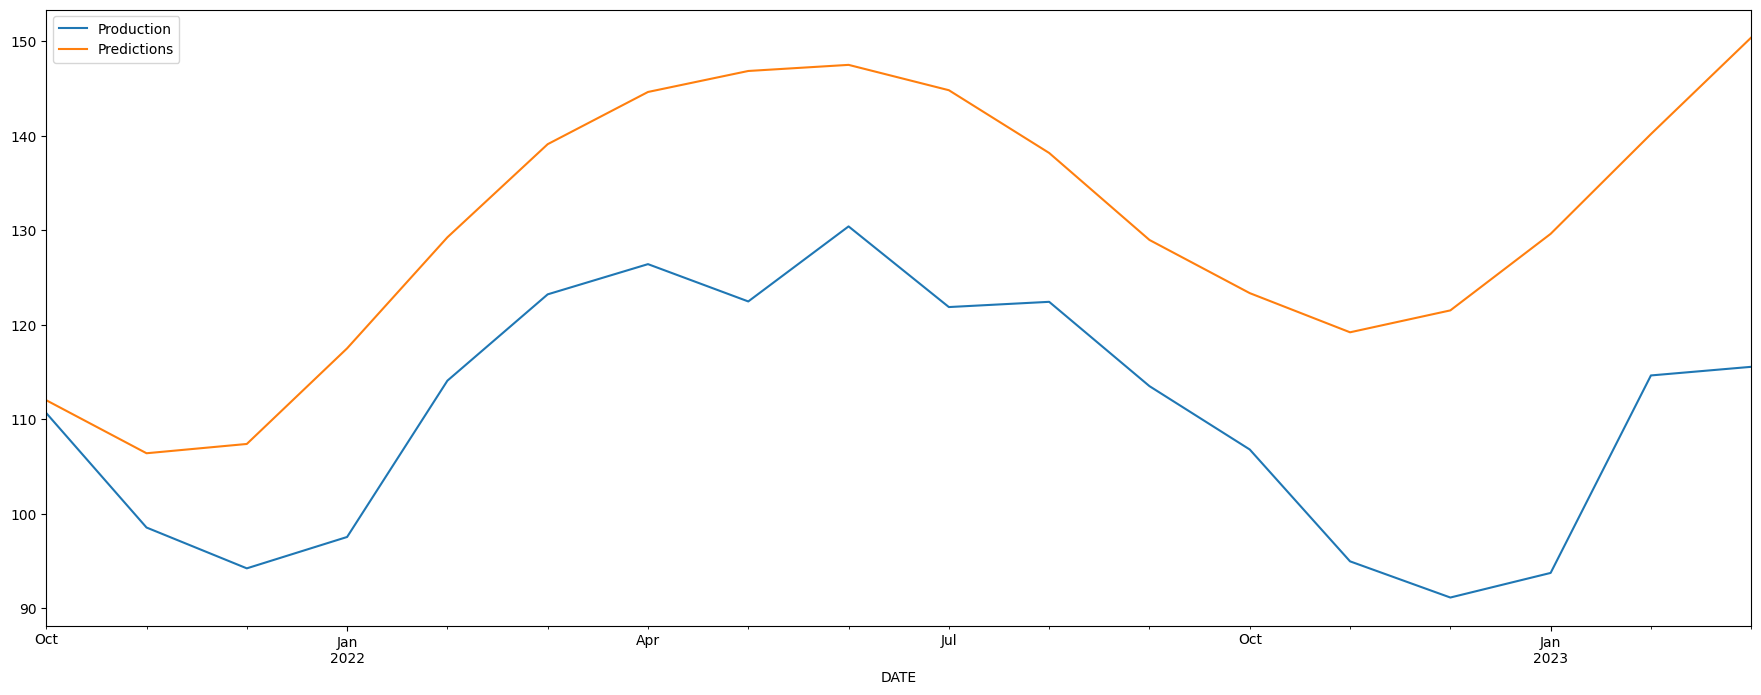

In [106]:
test.plot(figsize=(22,8))

## новые предсказания

In [107]:
full_scaler = MinMaxScaler()

In [108]:
scaler_full_data = full_scaler.fit_transform(df)

In [109]:
length = 12
generator = TimeseriesGenerator(scaler_full_data,scaler_full_data,length=length,batch_size=1)

In [111]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=6)

Epoch 1/6
603/603 [==============================] - 4s 6ms/step - loss: 0.0189
Epoch 2/6
603/603 [==============================] - 3s 5ms/step - loss: 0.0066
Epoch 3/6
603/603 [==============================] - 3s 5ms/step - loss: 0.0063
Epoch 4/6
603/603 [==============================] - 3s 6ms/step - loss: 0.0052
Epoch 5/6
603/603 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 6/6
603/603 [==============================] - 4s 6ms/step - loss: 0.0045


In [112]:
forecast = []

periode = 12

first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periode):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [113]:
forecast = full_scaler.inverse_transform(forecast)

In [114]:
df

,Production
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335
...,...
2022-11-01,94.9638
2022-12-01,91.1341
2023-01-01,93.7389


In [115]:
forecast

array([[105.10548188],
       [100.23520359],
       [101.61201146],
       [108.03411859],
       [115.39055502],
       [121.59240562],
       [125.47145346],
       [127.56561543],
       [128.44287499],
       [126.63389311],
       [121.23468254],
       [112.67547647]])

In [116]:
forecast_index = pd.date_range(start='2023-04-01',periods=periode,freq='MS')

In [117]:
forecast_index

DatetimeIndex(['2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01'],
              dtype='datetime64[ns]', freq='MS')

In [118]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [55]:
forecast_df

,Forecast
2023-04-01,106.731342
2023-05-01,108.300211
2023-06-01,108.690743
2023-07-01,108.823041
2023-08-01,106.755122
2023-09-01,99.982471
2023-10-01,92.743926
2023-11-01,87.180085
2023-12-01,91.096038
2024-01-01,98.369086


<Axes: >

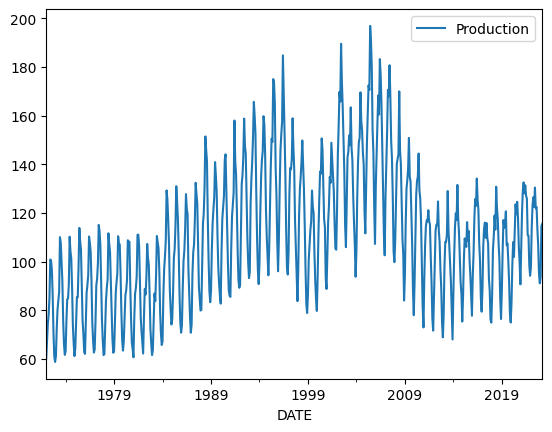

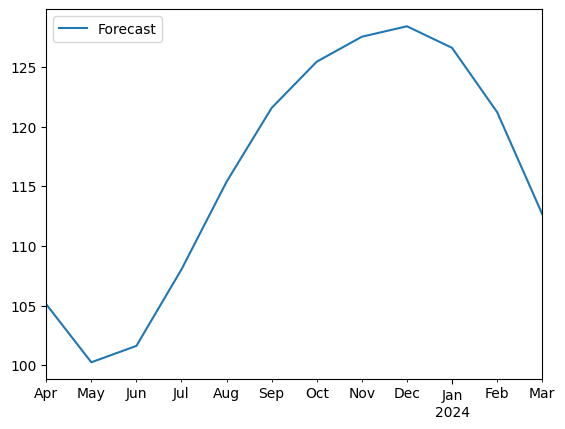

In [119]:
df.plot()
forecast_df.plot()

(576.0, 651.0)

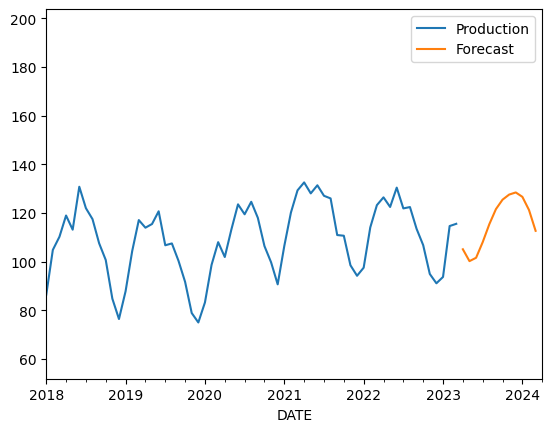

In [120]:
ax=df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2024-04-01')